In [3]:
import pandas as pd
import numpy as np
import sklearn
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from mpl_toolkits.basemap import Basemap
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

In [5]:
query_string1 = '''
                select * from merged order by pickup_datetime asc
'''

In [6]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaximergeddb.sqlite')
# Confirm data is being returned from this query
df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
df = df.drop('index', axis=1)
df.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947,CSH,5.5,0.5,0.5,0.00,0.0,6.50
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271,CRD,14.5,0.5,0.5,2.00,0.0,17.50
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272,CRD,4.0,0.5,0.5,1.00,0.0,6.00
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572,CRD,7.5,0.5,0.5,1.11,0.0,9.61
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791,CSH,7.5,0.5,0.5,0.00,0.0,8.50


In [7]:
df.shape[0]

14064068

Which rate codes occur most often?

In [8]:
df.rate_code.value_counts(normalize=True)*100

1      99.849361
4       0.063324
2       0.050178
5       0.027069
0       0.005425
3       0.004280
6       0.000249
210     0.000071
65      0.000014
206     0.000007
77      0.000007
9       0.000007
7       0.000007
Name: rate_code, dtype: float64

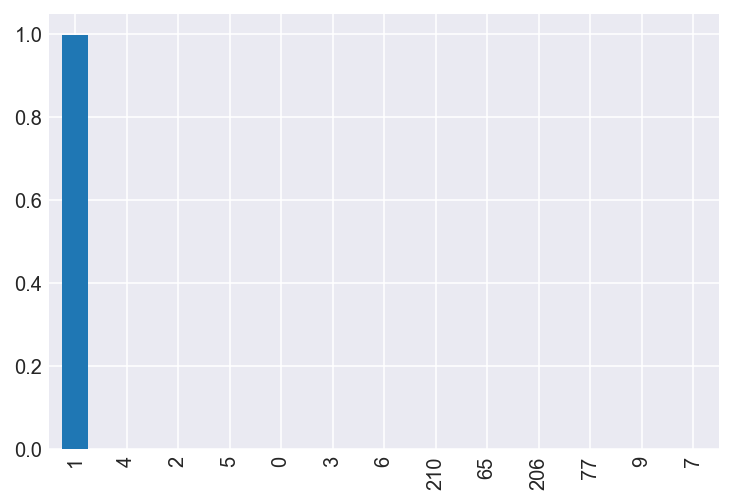

In [9]:
df.rate_code.sort_index(ascending=True).value_counts(normalize=True).plot(kind='bar')
None

In [10]:
# Let's filter down to Rate codes 1, 2 and 3 - NYC and its surrounding airports.
taxidf = df.copy()
taxidf = taxidf[taxidf.rate_code < 4]

# Linear Models
---
### Start by looking at the distribution of fare amount

In [11]:
# Confirm we don't have any fares below $2.50, the minimum rate charge
taxidf.fare_amount.min()

2.5

In [12]:
taxidf.fare_amount.max()

204.0

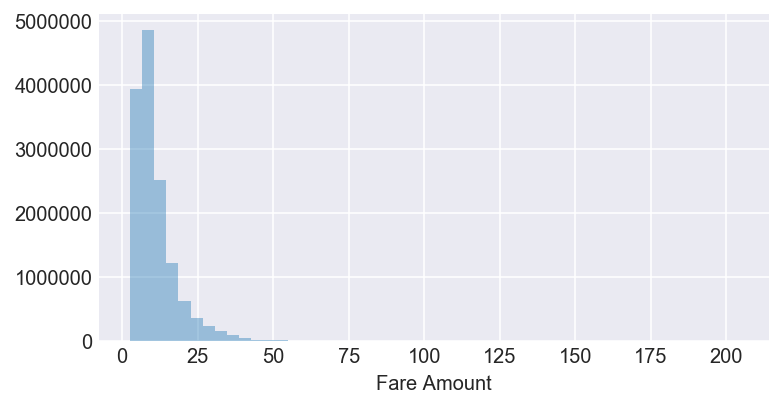

In [13]:
# Distribution seems to follow the log or power law
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(taxidf.fare_amount, kde=False)
ax.set_xlabel('Fare Amount')
None

The distribution of Fare Amount is right skewed. We are not able to add together

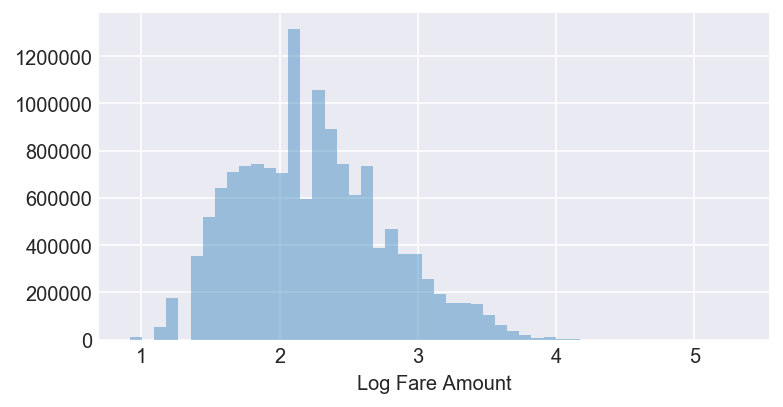

In [14]:
# Taking logs we appear to have a graph which looks slightly normal
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(np.log(taxidf.fare_amount), kde=False)
ax.set_xlabel('Log Fare Amount')
None

In [15]:
taxidf['LogFare'] = taxidf.fare_amount.map(np.log)
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,LogFare
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,2.484907
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,3.526361
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,1.609438
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,2.014903
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,1.945910


## Feature Engineering

In [16]:
# Let's codify time of day and day of week
taxidf.pickup_datetime = pd.to_datetime(taxidf.pickup_datetime)
taxidf['pickup_hour'] = taxidf.pickup_datetime.dt.hour
taxidf.head()
#taxidf['dropoff_hour'] = taxidf.dropoff_datetime.dt.hour

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,LogFare,pickup_hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,2.484907,0
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,3.526361,0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,1.609438,0
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,2.014903,0
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,1.945910,0


In [17]:
taxidf.dropoff_datetime = pd.to_datetime(taxidf.dropoff_datetime)
taxidf['dropoff_hour'] = taxidf.dropoff_datetime.dt.hour
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,LogFare,pickup_hour,dropoff_hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,2.484907,0,0
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,3.526361,0,0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,1.609438,0,0
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,2.014903,0,0
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,1.945910,0,0


In [18]:
# 0 = Monday and 6 = Sunday
taxidf['dayofweek'] = taxidf.pickup_datetime.dt.dayofweek
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,LogFare,pickup_hour,dropoff_hour,dayofweek
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,2.484907,0,0,0
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,3.526361,0,0,0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,1.609438,0,0,0
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,2.014903,0,0,0
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,1.945910,0,0,0


In [19]:
# Day of Month
taxidf['dayofmonth'] = taxidf.pickup_datetime.dt.day
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,LogFare,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,2.484907,0,0,0,1
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,3.526361,0,0,0,1
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,1.609438,0,0,0,1
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,2.014903,0,0,0,1
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,1.945910,0,0,0,1


In [20]:
# Speed in miles per hour
taxidf['speed'] = 1.0*taxidf.trip_distance/(taxidf.trip_time_in_secs/3600.)
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,LogFare,pickup_hour,dropoff_hour,dayofweek,dayofmonth,speed
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,2.484907,0,0,0,1,19.367089
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,3.526361,0,0,0,1,17.640000
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,1.609438,0,0,0,1,14.550000
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,2.014903,0,0,0,1,16.900000
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,1.945910,0,0,0,1,21.840000


In [21]:
# This is ludicrous
taxidf.speed.max()

74880.0

In [22]:
#Filter down to all trips below 200mph
taxidf = taxidf[taxidf['speed'] < 200]

## Use correlation matrix to identify pertinent features

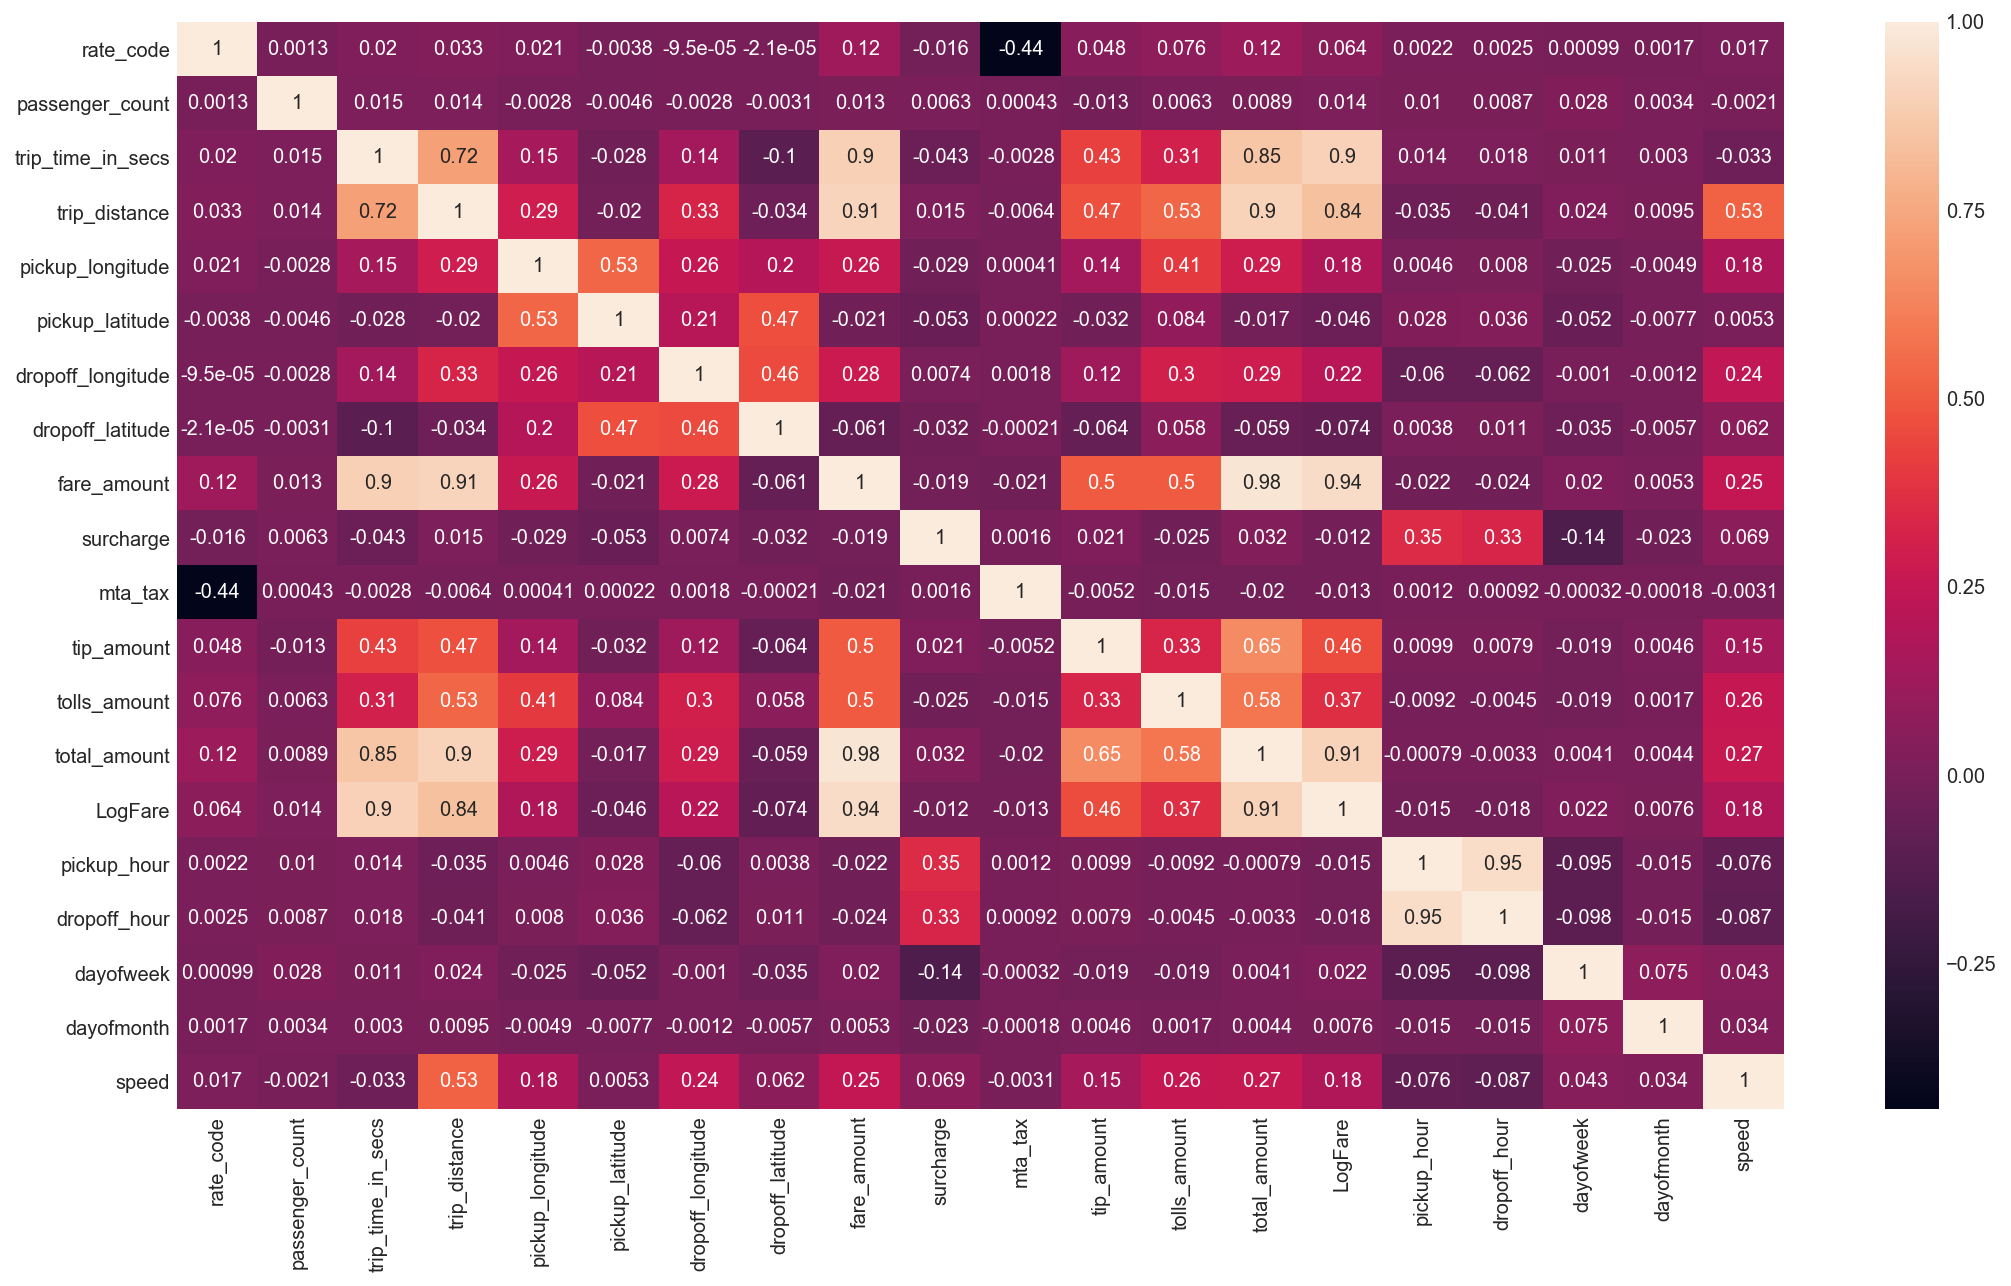

In [23]:
taxidf_corrmat = taxidf.corr()
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.heatmap(taxidf_corrmat, annot = True)
None

Log fare is highly correlated to: 
* trip time in secs 
* distance 

There isa also a weak correlation to: 
* speed, 
* tip amount, 
* tolls amount, 
* pickup longitude and 
* dropoff longitude

## Baseline model
---
The dummy regressor here uses the average of LogFare to predict the value of LogFare

In [24]:
features = taxidf[['trip_time_in_secs','trip_distance','speed','tip_amount','tolls_amount']]
target = taxidf.LogFare
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-6.4361931340073397e-09

## Linear Models

In [25]:
# Basic Linear Model
y = taxidf.LogFare
X = taxidf[['trip_time_in_secs','trip_distance','speed','tip_amount','tolls_amount']]

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [27]:
ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [28]:
# Print R_squared
print "The R-squared of the RANSAC model is: ", ransac.score(X_test, y_test)
print "The R-squared of the Huber model is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model is: ", ols.score(X_test, y_test)

The R-squared of the RANSAC model is:  0.85597245093
The R-squared of the Huber model is:  0.855093322558
The R-squared of the OLS model is:  0.885657164037


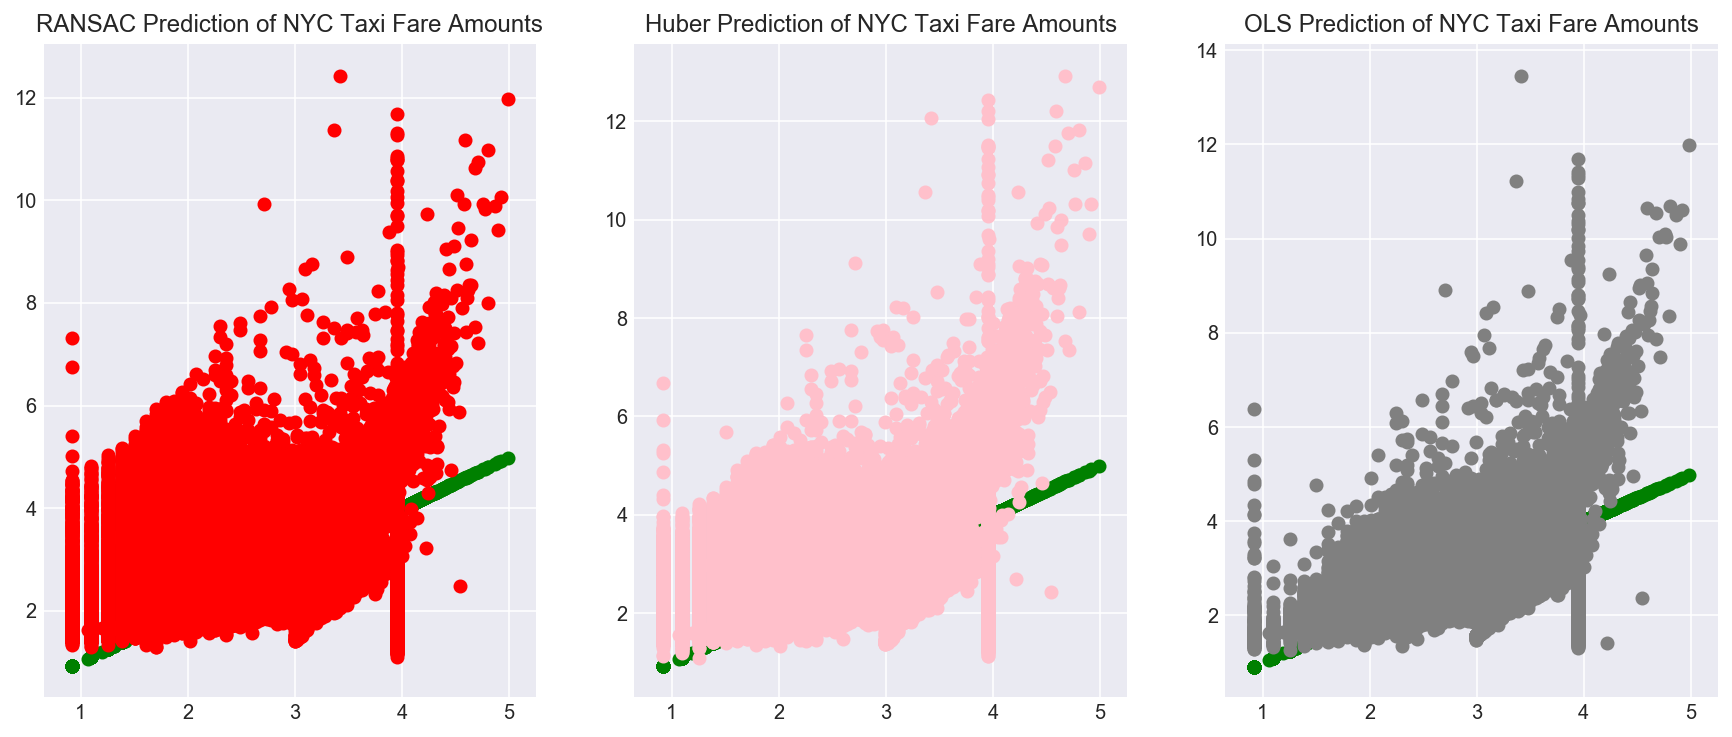

In [29]:
ypred_ols = ols.predict(X_test)
ypred_r = ransac.predict(X_test)
ypred_h = huber.predict(X_test)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_r, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Fare Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Fare Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Fare Amounts')
#ax4.scatter(y_test, y_test, c='green')
#ax4.scatter(y_test, ypred_r, c='orange')
#ax4.set_title('Theil-Sen Prediction of House Prices using Fixed Home Characteristics')
None

OLS model does the best, explaining upto 88.5% of variance of taxi fares.
 
R-squared is not the only metric by which we should judge how good our model is. Another approach is to determine how far off our prediction was from the actual sale price of the house.

In [30]:
# Median Absolute Error
from sklearn.metrics import median_absolute_error, r2_score
print "Using OLS Regression on average our estimate of taxi fare misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our estimate of taxi fares misses by", \
median_absolute_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of taxi fares misses by", \
median_absolute_error(huber.predict(X_test), y_test)

Using OLS Regression on average our estimate of taxi fare misses by 0.0907038356171
Using RANSAC Regression on average our estimate of taxi fares misses by 0.0828029796579
Using Huber Regression on average our estimate of taxi fares misses by 0.0715800989417


What if we look at the actual fare as the target variable instead of Log Fare Amount?

In [31]:
features = taxidf[['trip_time_in_secs','trip_distance','speed','tip_amount','tolls_amount']]
target = taxidf.fare_amount
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-1.892525487434682e-07

In [32]:
# Basic Linear Model

y = taxidf.LogFare
X = taxidf[['trip_time_in_secs','trip_distance','speed','tip_amount','tolls_amount']]

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [34]:
ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [35]:
# Print R_squared
print "The R-squared of the RANSAC model is: ", ransac.score(X_test, y_test)
print "The R-squared of the Huber model is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model is: ", ols.score(X_test, y_test)

The R-squared of the RANSAC model is:  0.953165199389
The R-squared of the Huber model is:  0.951252792805
The R-squared of the OLS model is:  0.95558052435


In [36]:
ypred_ols = ols.predict(X_test)
ypred_r = ransac.predict(X_test)
ypred_h = huber.predict(X_test)

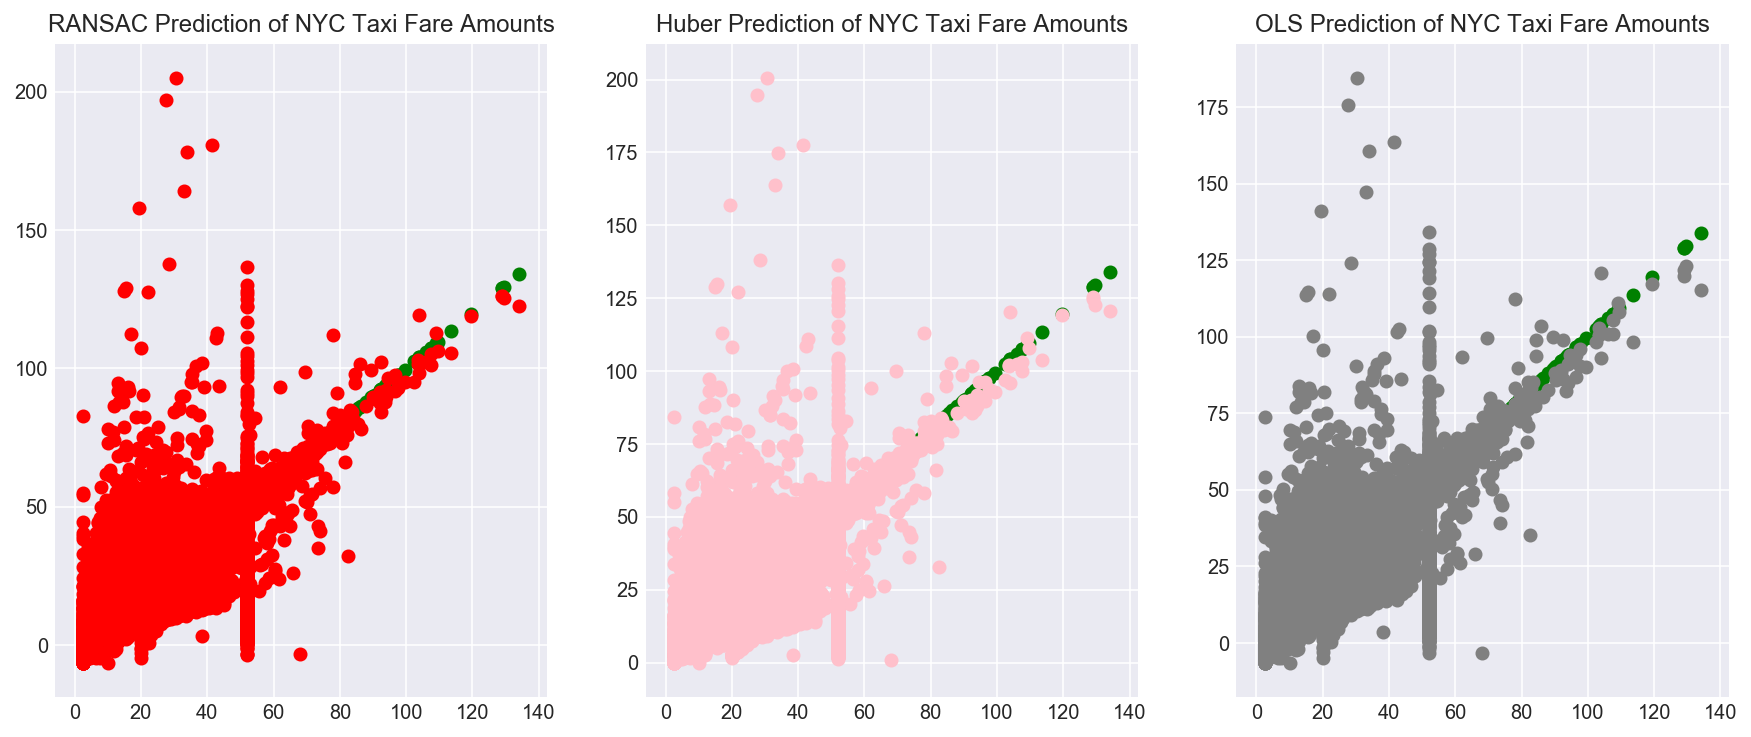

In [37]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_r, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Fare Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Fare Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Fare Amounts')
#ax4.scatter(y_test, y_test, c='green')
#ax4.scatter(y_test, ypred_r, c='orange')
#ax4.set_title('Theil-Sen Prediction of House Prices using Fixed Home Characteristics')
None

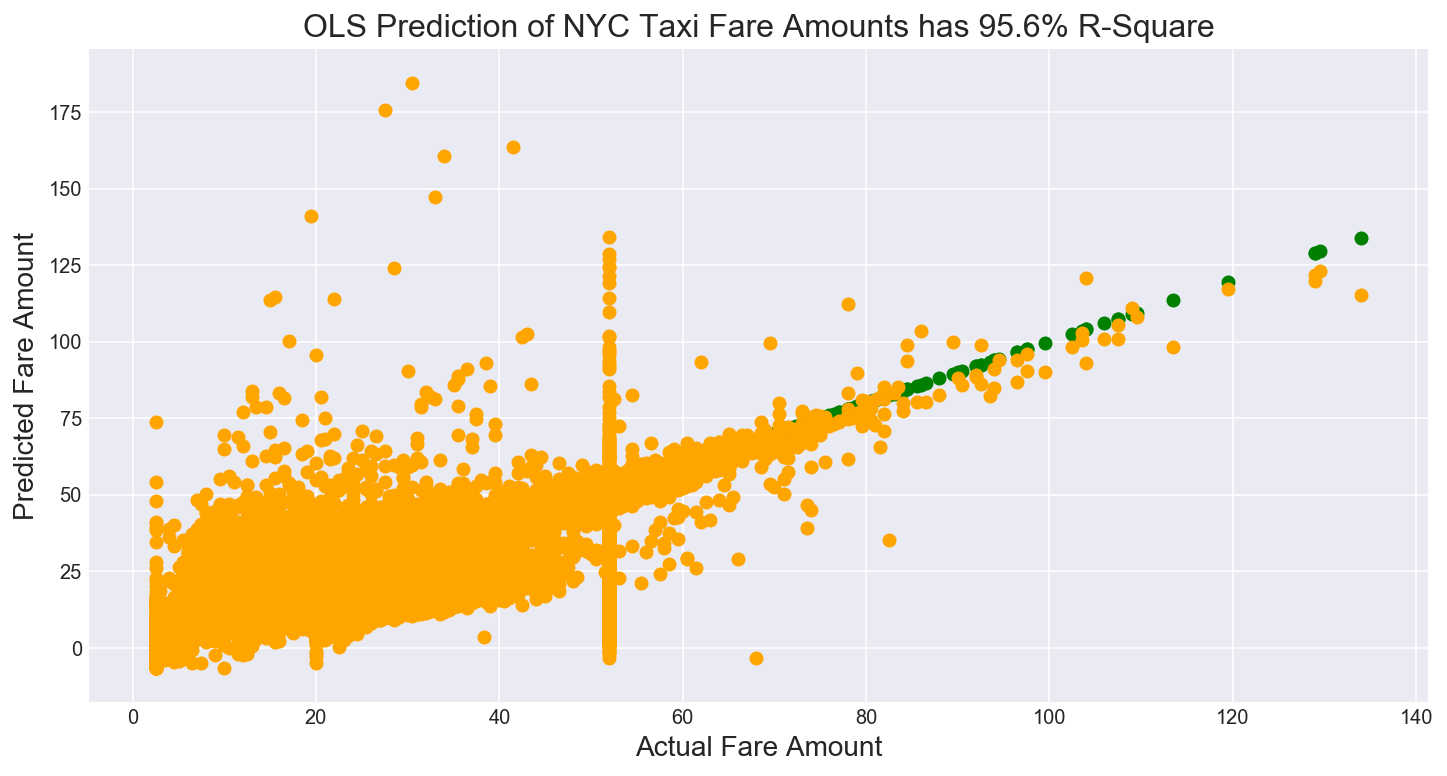

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_ols, c='orange')
ax.set_title('OLS Prediction of NYC Taxi Fare Amounts has 95.6% R-Square', fontsize=16)
ax.set_ylabel('Predicted Fare Amount', fontsize=14)
ax.set_xlabel('Actual Fare Amount', fontsize=14)
None

In [39]:
import statsmodels.api as sm
y = taxidf.fare_amount
X1 = taxidf[['trip_time_in_secs','trip_distance','speed','tip_amount','tolls_amount']]
X1 = sm.add_constant(X1)
res1 = sm.OLS(y, X1, missing='drop').fit()
print(res1.summary())

/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 6.058e+07
Date:                Sat, 18 Nov 2017   Prob (F-statistic):               0.00
Time:                        22:24:53   Log-Likelihood:            -2.4542e+07
No. Observations:            14045346   AIC:                         4.908e+07
Df Residuals:                14045340   BIC:                         4.908e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.7425      0.00

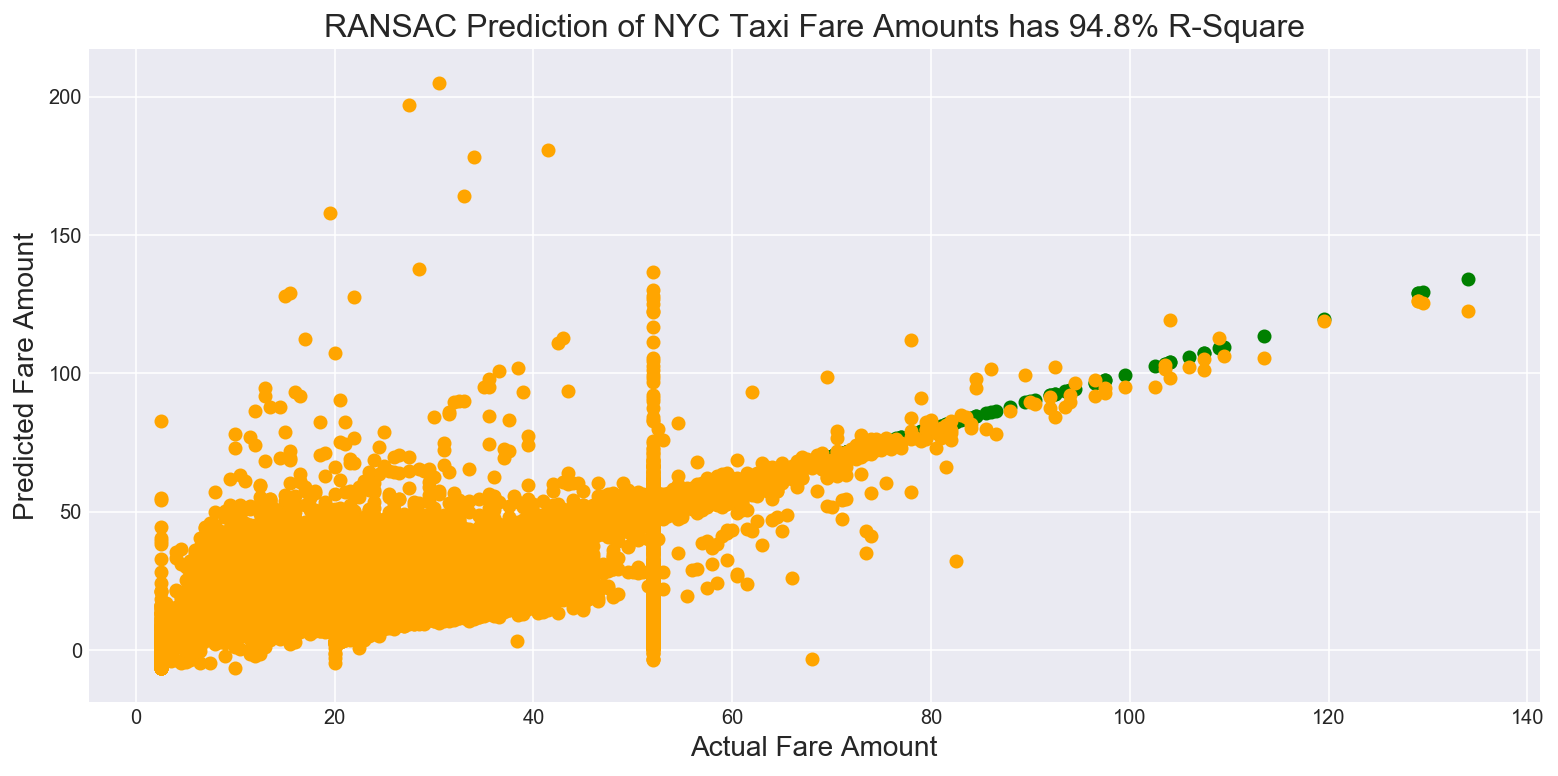

In [40]:
fig, ax = plt.subplots(figsize=(13,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_r, c='orange')
ax.set_title('RANSAC Prediction of NYC Taxi Fare Amounts has 94.8% R-Square', fontsize=16)
ax.set_ylabel('Predicted Fare Amount', fontsize=14)
ax.set_xlabel('Actual Fare Amount', fontsize=14)
None

## 5-Fold Cross Validation
---
How well does our model do after I apply a 5 Fold Cross Validation?

In [41]:
ransac = RANSACRegressor()
y = taxidf.LogFare
X = taxidf[['trip_time_in_secs','trip_distance','speed','tip_amount','tolls_amount']]
sklearn.model_selection.cross_val_score(ransac, X, y, cv=5)

array([ 0.83144556,  0.84609247,  0.84090282,  0.79703588,  0.80913543])

In [42]:
sklearn.model_selection.cross_val_score(ransac, X, y, cv=5).mean()

0.83730844692739093